# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward 

> **Note**: This Jupyter notebook was generated with AI assistance. Please review code and results carefully.

## Overview
This notebook explores data from [DANDI:001361](https://dandiarchive.org/dandiset/001361/0.250406.0045), which contains 2-photon calcium imaging data from mouse hippocampal area CA1 during virtual reality navigation. The study investigates how hippocampal neurons encode sequences of events relative to reward locations.

This notebook demonstrates:
- Loading and accessing NWB files from the dandiset
- Exploring behavioral data including position, speed, and reward timing
- Analyzing calcium imaging data and ROI properties
- Visualizing key neural and behavioral variables

## Required Packages

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
from dandi.dandiapi import DandiAPIClient
import seaborn as sns

## Loading Data from DANDI

In [2]:
# Initialize DANDI API client
client = DandiAPIClient()
dandiset = client.get_dandiset("001361", "0.250406.0045")

# Get URL for example session
url = next(dandiset.get_assets_by_glob("sub-m11/sub-m11_ses-05_behavior+ophys.nwb")).download_url

# Load NWB file via streaming
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Exploring Behavioral Data

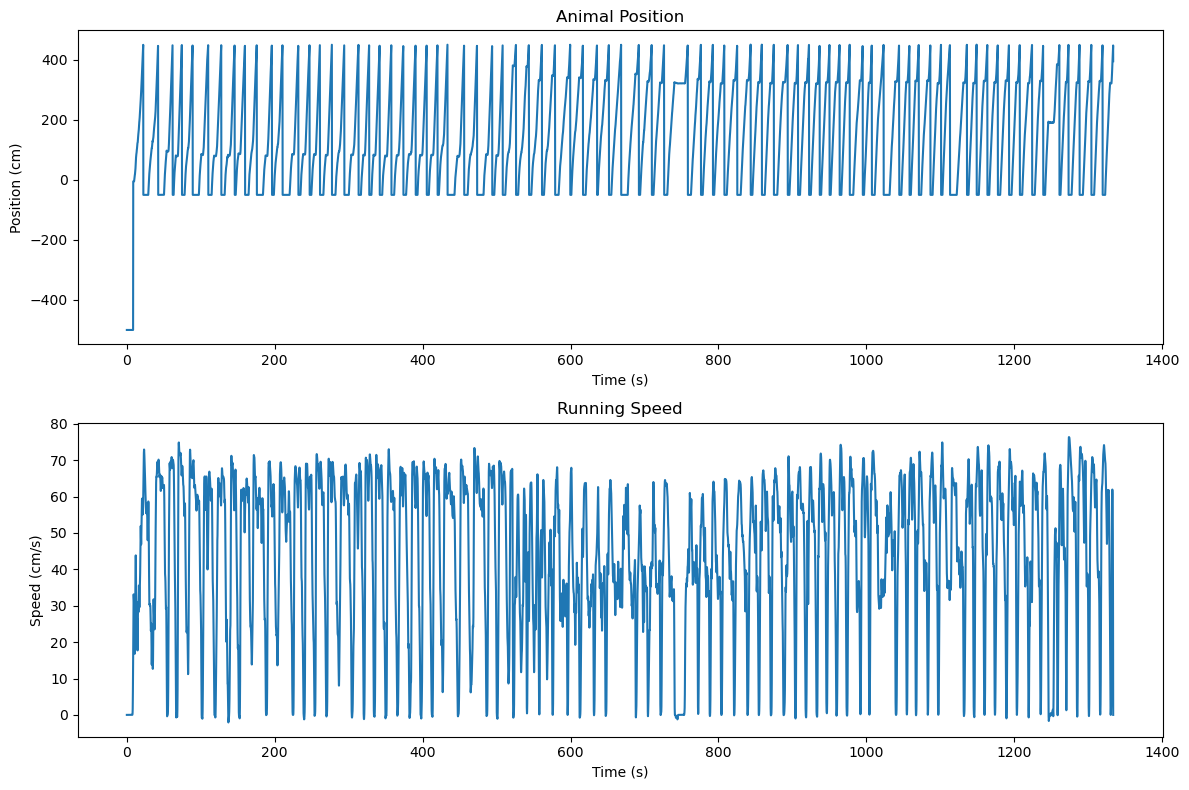

In [3]:
# Access behavioral time series
behavior = nwb.processing['behavior'].data_interfaces['BehavioralTimeSeries']

# Extract position, speed and timestamps
position = behavior.time_series['position'].data[:]
speed = behavior.time_series['speed'].data[:]
timestamps = behavior.time_series['position'].timestamps[:]

# Plot position and speed over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(timestamps, position)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (cm)')
ax1.set_title('Animal Position')

ax2.plot(timestamps, speed)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Speed (cm/s)')
ax2.set_title('Running Speed')

plt.tight_layout()
plt.show()

## Analyzing Reward Events

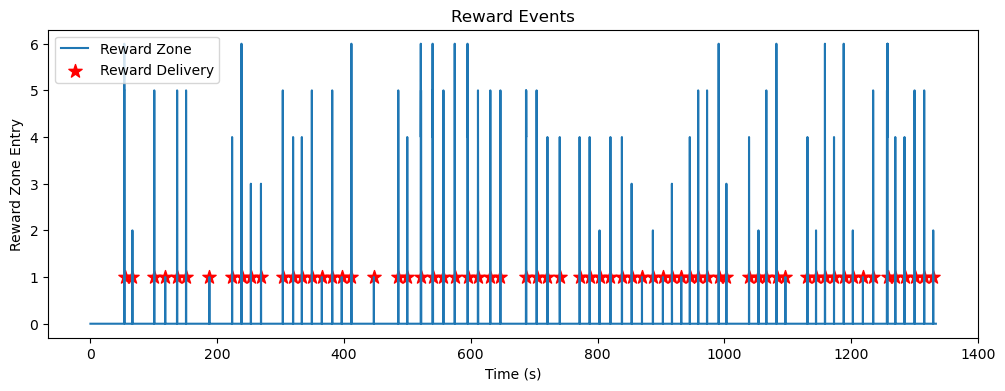

In [4]:
# Get reward delivery times and amounts
reward_times = behavior.time_series['Reward'].timestamps[:]
reward_amounts = behavior.time_series['Reward'].data[:]

# Get reward zone entries
reward_zone = behavior.time_series['reward_zone'].data[:]
rz_timestamps = behavior.time_series['reward_zone'].timestamps[:]

# Plot reward events
plt.figure(figsize=(12, 4))
plt.plot(rz_timestamps, reward_zone, label='Reward Zone')
plt.scatter(reward_times, np.ones_like(reward_times), 
           color='red', marker='*', s=100, label='Reward Delivery')
plt.xlabel('Time (s)')
plt.ylabel('Reward Zone Entry')
plt.title('Reward Events')
plt.legend()
plt.show()

## Exploring Calcium Imaging Data

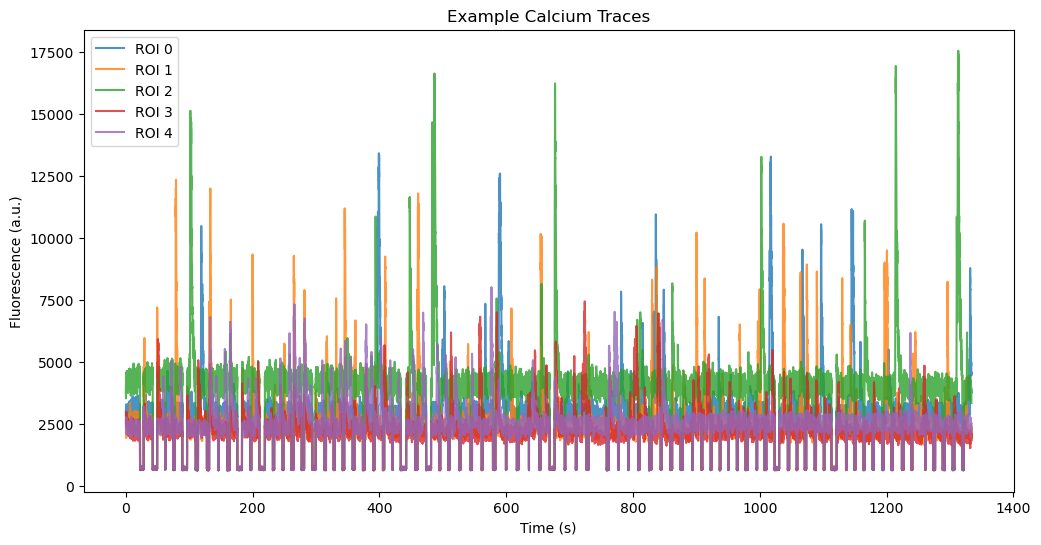

In [5]:
# Access fluorescence data
fluorescence = nwb.processing['ophys'].data_interfaces['Fluorescence']
f_traces = fluorescence.roi_response_series['plane0'].data[:] # Shape: (time, ROIs)

# Plot example calcium traces
plt.figure(figsize=(12, 6))
for i in range(5):  # Plot first 5 ROIs
    plt.plot(timestamps, f_traces[:, i] + i*5, alpha=0.8, label=f'ROI {i}')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.)')
plt.title('Example Calcium Traces')
plt.legend()
plt.show()

## ROI Properties

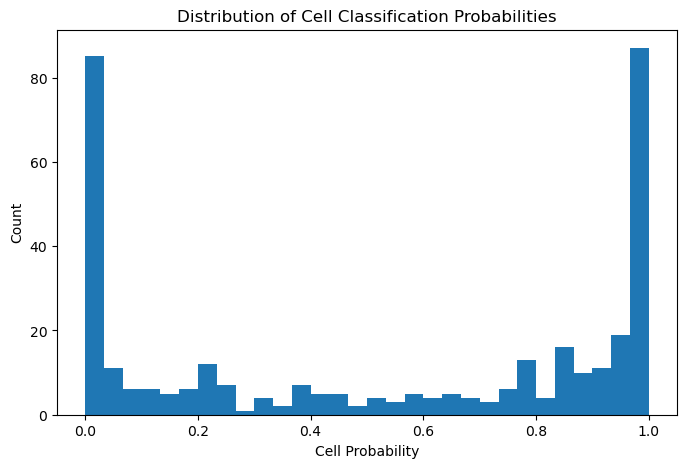

In [6]:
# Get ROI/cell information
plane_seg = nwb.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
iscell = plane_seg.iscell[:]  # Array containing cell classification

# Plot distribution of cell probabilities
plt.figure(figsize=(8, 5))
plt.hist(iscell[:, 1], bins=30)
plt.xlabel('Cell Probability')
plt.ylabel('Count')
plt.title('Distribution of Cell Classification Probabilities')
plt.show()

## Neural Activity Aligned to Behavior

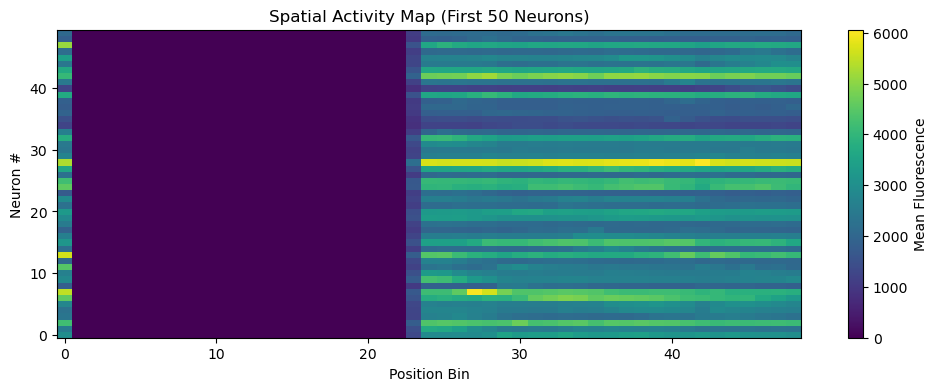

In [7]:
# Create a position-binned activity matrix
pos_bins = np.linspace(position.min(), position.max(), 50)
pos_indices = np.digitize(position, pos_bins)

# Calculate mean activity for each position bin
activity_map = np.zeros((len(pos_bins)-1, f_traces.shape[1]))
for i in range(len(pos_bins)-1):
    bin_mask = pos_indices == i+1
    if np.any(bin_mask):
        activity_map[i] = np.mean(f_traces[bin_mask], axis=0)

# Plot spatial activity for example neurons
plt.figure(figsize=(12, 4))
plt.imshow(activity_map[:, :50].T, aspect='auto', origin='lower')
plt.colorbar(label='Mean Fluorescence')
plt.xlabel('Position Bin')
plt.ylabel('Neuron #')
plt.title('Spatial Activity Map (First 50 Neurons)')
plt.show()

## Next Steps
This notebook demonstrated basic access and visualization of the behavioral and neural data from this dataset. Potential next analyses could include:
- Aligning neural activity to specific behavioral events
- Investigating changes in spatial coding across the session
- Analyzing population dynamics during reward approach and consumption
- Comparing coding properties across different sessions or animals